# 1. Mô tả bộ dữ liệu
### Nguồn dữ liệu:
Dataset “NLP Getting Started” được chia sẻ trên Kaggle thông qua cuộc thi NLP Getting Started. Dữ liệu gồm các tweet về thiên tai, kèm nhãn xác định tweet có thực sự liên quan đến thiên tai hay không.
### Mục tiêu bài toán:
Xây dựng mô hình phân loại nhị phân (binary classification):
- target = 1: Tweet thực sự liên quan đến thiên tai.
- target = 0: Tweet không liên quan.

→ Đây là bài toán phân loại nhị phân (binary classification) trong lĩnh vực NLP.
### Quy mô dữ liệu:
- Train: 7,613 dòng, 5 cột (id, keyword, location, text, target).
- Test: 3,263 dòng, 4 cột (id, keyword, location, text).
- Một số cột có giá trị thiếu, đặc biệt location (~33%), keyword (~0.8%).
### Các thuộc tính chính:
| Thuộc tính | Mô tả                                                        | Kiểu dữ liệu                     |
| ---------- | ------------------------------------------------------------ | -------------------------------- |
| id         | Mã định danh tweet                                           | Numeric                          |
| keyword    | Từ khóa nổi bật trong tweet                                  | Categorical/Text                 |
| location   | Vị trí tweet được gửi từ đâu                                 | Categorical/Text                 |
| text       | Nội dung tweet                                               | Text                             |
| target     | Nhãn phân loại: 1 = liên quan thiên tai, 0 = không liên quan | Numeric (Target, chỉ có ở train) |

### Đặc điểm dữ liệu:

- Giá trị thiếu:

  - keyword: 61/7613 (0.8%)

  - location: 2,533/7,613 (33.3%)

  - text và target không thiếu.

- Đặc điểm text:

  - Độ dài trung bình ~101 ký tự, tối đa 157 ký tự.

  - Có hashtag (1,761 tweet), @mention (2,039 tweet), link (3,971 tweet).

- Target:

  - 0 = 4,342, 1 = 3,271 → phân bố gần cân bằng.

- Một số cột phân loại (keyword, location) cần mã hóa trước khi đưa vào mô hình.

- Dữ liệu text cần tiền xử lý NLP: lowercase, loại bỏ stopword, tokenization, vectorization/embedding.

### Chất lượng và xử lý dữ liệu:

- Dữ liệu tương đối sạch, chỉ cần xử lý missing values và text preprocessing.

- Có thể áp dụng:

  - Label Encoding / One-Hot Encoding cho keyword, location.

  - TF-IDF, Word2Vec, BERT embedding cho cột text.

### Ứng dụng và phạm vi sử dụng:

- Phân loại tweet liên quan thiên tai để:

  - Hỗ trợ giám sát và cảnh báo thiên tai.

  - Lọc thông tin quan trọng trong mạng xã hội.

  - Phân tích hành vi và phản ứng của cộng đồng với thiên tai.

- Bộ dữ liệu thích hợp cho các mô hình NLP:

  - Logistic Regression, Random Forest, Gradient Boosting, SVM, hoặc mô hình deep learning như LSTM, BERT.

# 2/ Quy trình chia dữ liệu và huấn luyện mô hình Naive Bayes

## 2.1 Tải và đọc dữ liệu

In [ ]:
!pip install -q kaggle

import os
os.environ['KAGGLE_USERNAME'] = "user-name" # Thay bằng user name của bạn
os.environ['KAGGLE_KEY'] = "api-key"        # Thay bằng api-key của bạn

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

competition_name = "nlp-getting-started"
download_path = "./nlp_data"

os.makedirs(download_path, exist_ok=True)

api.competition_download_files(competition_name, path=download_path, quiet=False)

# Giải nén file ZIP sau khi tải
import zipfile
import glob
zip_files = glob.glob(os.path.join(download_path, "*.zip"))

for zf in zip_files:
    with zipfile.ZipFile(zf, 'r') as zip_ref:
        zip_ref.extractall(download_path)

import pandas as pd

train_path = os.path.join(download_path, "train.csv")
test_path = os.path.join(download_path, "test.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

for col in train_df.columns:
    print(f"\n--- Cột: {col} (Dtype: {train_df[col].dtype}) ---")

    if train_df[col].dtype == 'object':
        print("Các nhãn/giá trị độc nhất và tần suất:")
        print(train_df[col].value_counts(dropna=False).head(10))
        print(f"Tổng số giá trị độc nhất: {train_df[col].nunique()}")
        print(f"Tỷ lệ giá trị thiếu (NaN): {train_df[col].isnull().sum() / len(train_df) * 100:.2f}%")

        if train_df[col].apply(lambda x: isinstance(x, str)).any() and train_df[col].str.len().mean() > 10:
            avg_len = train_df[col].astype(str).apply(len).mean()
            max_len = train_df[col].astype(str).apply(len).max()
            print(f"→ Độ dài trung bình: {avg_len:.1f}, Độ dài tối đa: {max_len}")

            # Thống kê các đặc trưng văn bản cơ bản
            n_hashtags = train_df[col].astype(str).str.contains('#').sum()
            n_mentions = train_df[col].astype(str).str.contains('@').sum()
            n_links = train_df[col].astype(str).str.contains('http').sum()
            print(f"→ Tweet có hashtag: {n_hashtags}, có @mention: {n_mentions}, có link: {n_links}")

    elif train_df[col].dtype == 'int64':
        if train_df[col].nunique() <= 10:
            print("Các giá trị/nhãn số nguyên và tần suất:")
            print(train_df[col].value_counts(dropna=False))
        else:
            print(f"Số lượng giá trị độc nhất: {train_df[col].nunique()}. "
                  f"Giá trị nhỏ nhất: {train_df[col].min()}, lớn nhất: {train_df[col].max()}.")
        print(f"Tỷ lệ giá trị thiếu: {train_df[col].isnull().sum() / len(train_df) * 100:.2f}%")

    elif train_df[col].dtype == 'float64':
        print(f"Số lượng giá trị độc nhất: {train_df[col].nunique()}. "
              f"Giá trị nhỏ nhất: {train_df[col].min()}, lớn nhất: {train_df[col].max()}.")
        print(f"Tỷ lệ giá trị thiếu (NaN): {train_df[col].isnull().sum() / len(train_df) * 100:.2f}%")

print("THÔNG TIN TỔNG QUAN DỮ LIỆU TRAIN:")
print(train_df.info())
print("\n5 dòng đầu tiên:")
print(train_df.head())

print("THÔNG TIN TỔNG QUAN DỮ LIỆU TEST:")
print(test_df.info())
print("\n5 dòng đầu tiên:")
print(test_df.head())

100%|██████████| 593k/593k [00:00<00:00, 267MB/s]


--- Cột: id (Dtype: int64) ---
Số lượng giá trị độc nhất: 7613. Giá trị nhỏ nhất: 1, lớn nhất: 10873.
Tỷ lệ giá trị thiếu: 0.00%

--- Cột: keyword (Dtype: object) ---
Các nhãn/giá trị độc nhất và tần suất:
keyword
NaN            61
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
sinking        41
evacuate       40
outbreak       40
Name: count, dtype: int64
Tổng số giá trị độc nhất: 221
Tỷ lệ giá trị thiếu (NaN): 0.80%

--- Cột: location (Dtype: object) ---
Các nhãn/giá trị độc nhất và tần suất:
location
NaN                2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Name: count, dtype: int64
Tổng số giá trị độc nhất: 3341
Tỷ lệ giá trị thiếu (NaN): 33.27%
→ Độ dài trung bình: 10.1, Độ dài tối đa: 49
→ Tweet có hashtag: 52, có @mention: 33, có link: 3



## 2.2 Kiểm tra thông tin và xử lý dữ liệu

In [ ]:
import re
import string
import pandas as pd

print("Thông tin tổng quan:")
train_df.info()

print("\nGiá trị thiếu:")
print(train_df.isnull().sum())

# Điền giá trị thiếu
train_df['keyword'] = train_df['keyword'].fillna('unknown')
train_df['location'] = train_df['location'].fillna('unknown')

# Tiền xử lý văn bản
def clean_text(text):
    text = text.lower()  # viết thường
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  # bỏ URL
    text = re.sub(r"@\w+", " ", text)  # bỏ mention
    text = re.sub(r"#", " ", text)  # bỏ ký tự hashtag
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # bỏ dấu câu
    text = re.sub(r"\d+", " ", text)  # bỏ số
    text = re.sub(r"\s+", " ", text).strip()  # bỏ khoảng trắng thừa
    return text

train_df["text_clean"] = train_df["text"].apply(clean_text)

# Encode cột phân loại keyword & location (LabelEncoder)
from sklearn.preprocessing import LabelEncoder
label_cols = ["keyword", "location"]
for col in label_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))

print("\nSau khi xử lý và mã hóa:")
print(train_df[["text", "text_clean", "keyword", "location"]].head())


Thông tin tổng quan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Giá trị thiếu:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Sau khi xử lý và mã hóa:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          text_clean  keyword  location  
0  o

## 2.3 Chia dữ liệu train/test và vector hóa text

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# Kết hợp text + keyword + location thành một chuỗi chung (cải thiện ngữ cảnh)
train_df["text_full"] = (
    train_df["text_clean"].astype(str) + " " +
    train_df["keyword"].astype(str) + " " +
    train_df["location"].astype(str)
)

# Tách X và y
X_text = train_df["text_full"]
y = train_df["target"]

# Vector hóa TF-IDF
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),        # thêm bigram
    min_df=3,                  # bỏ từ quá hiếm
    sublinear_tf=True,
    stop_words="english"
)
X_text_vec = tfidf.fit_transform(X_text)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_text_vec, y, test_size=0.3, random_state=42, stratify=y
)

print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape)


Kích thước tập huấn luyện: (5329, 7207)
Kích thước tập kiểm tra: (2284, 7207)


## 2.4 Huấn luyện mô hình Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Khởi tạo mô hình
nb = MultinomialNB()

# Lưới tham số mở rộng
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0],
    'fit_prior': [True, False]
}


# GridSearchCV
grid_nb = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Huấn luyện
grid_nb.fit(X_train, y_train)

# Kết quả tốt nhất
print("Best Parameters:", grid_nb.best_params_)
print("Best CV Accuracy:", grid_nb.best_score_)

# Dự đoán
y_pred = grid_nb.best_estimator_.predict(X_test)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Parameters: {'alpha': 0.75, 'fit_prior': False}
Best CV Accuracy: 0.789828325802218


## 2.5 Đánh giá mô hình

Accuracy: 0.8134851138353766

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1303
           1       0.80      0.75      0.78       981

    accuracy                           0.81      2284
   macro avg       0.81      0.81      0.81      2284
weighted avg       0.81      0.81      0.81      2284


Ma trận nhầm lẫn:


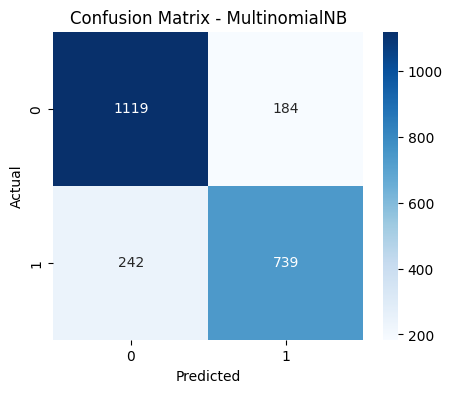

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nMa trận nhầm lẫn:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MultinomialNB')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
